<a href="https://colab.research.google.com/github/qasimramzankbk/Qasi/blob/main/LSTM_plus_Attn_Adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq


In [ ]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.15.0


In [ ]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582672,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200


In [ ]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))


In [ ]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])


In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

# # Model initialization
# model = Sequential()

# # Adding the first LSTM layer
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# # Adding additional LSTM layers
# model.add(LSTM(units=50, return_sequences=True))
# model.add(LSTM(units=50))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


Epoch 1/100
25/25 [==============================] - 24s 345ms/step - loss: 0.0444 - val_loss: 0.0066
Epoch 2/100
25/25 [==============================] - 5s 200ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 3/100
25/25 [==============================] - 5s 216ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 4/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5/100
25/25 [==============================] - 4s 155ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 6/100
25/25 [==============================] - 4s 144ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 8/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0020 - val_loss:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)



Epoch 1/100
25/25 [==============================] - 7s 99ms/step - loss: 0.0486 - val_loss: 0.0095
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 3/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 4/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 6/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 7/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 9/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0037 - val_loss: 0.0068

In [ ]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Assume 'data' is your preprocessed dataset
train_size = int(len(aapl_data) * 0.8)
train_data, test_data = aapl_data[:train_size], aapl_data[train_size:]


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)             

In [ ]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


Epoch 1/100
25/25 [==============================] - 6s 84ms/step - loss: 0.8893 - val_loss: 0.3156
Epoch 2/100
25/25 [==============================] - 2s 71ms/step - loss: 0.5241 - val_loss: 0.3940
Epoch 3/100
25/25 [==============================] - 2s 72ms/step - loss: 0.3054 - val_loss: 0.3430
Epoch 4/100
25/25 [==============================] - 1s 53ms/step - loss: 0.2462 - val_loss: 0.3178
Epoch 5/100
25/25 [==============================] - 1s 50ms/step - loss: 0.2184 - val_loss: 0.2681
Epoch 6/100
25/25 [==============================] - 1s 57ms/step - loss: 0.1949 - val_loss: 0.2521
Epoch 7/100
25/25 [==============================] - 1s 56ms/step - loss: 0.1740 - val_loss: 0.2423
Epoch 8/100
25/25 [==============================] - 1s 54ms/step - loss: 0.1559 - val_loss: 0.2327
Epoch 9/100
25/25 [==============================] - 1s 51ms/step - loss: 0.1442 - val_loss: 0.1864
Epoch 10/100
25/25 [==============================] - 1s 51ms/step - loss: 0.1241 - val_loss: 0.1750

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0092 - val_loss: 0.0016
Epoch 2/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0099 - val_loss: 7.0570e-04
Epoch 3/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0102 - val_loss: 0.0024
Epoch 4/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 5/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0089 - val_loss: 6.8648e-04
Epoch 6/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 7/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 8/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0101 - val_loss: 0.0015
Epoch 9/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 10/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0089 - val_loss

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)


Epoch 1/100
25/25 [==============================] - 2s 56ms/step - loss: 0.0093 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/100
 3/25 [==>...........................] - ETA: 1s - loss: 0.0125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 55ms/step - loss: 0.0103 - val_loss: 0.0036 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0112 - val_loss: 8.0382e-04 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0075 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0099 - val_loss: 8.3921e-04 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0098 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 55ms/step - loss: 0.0082 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0077 - val_loss: 6.3762e-04 - lr: 0.0010
Epoch 9/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0117 - val_loss: 0.0043 - lr: 0.0010
Epoch 10/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0084 - val_loss: 5.

In [ ]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)



6/6 [==============================] - 0s 17ms/step - loss: 0.0049
Test Loss:  0.004919029772281647


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


6/6 [==============================] - 1s 17ms/step
Mean Absolute Error:  0.06713882717183005
Root Mean Square Error:  0.07013579884276223


In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step
Predicted Stock Prices for the next 4 days:  [[172.07568]]


In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step
Predicted Stock Prices for the next 4 days:  [172.07568, 172.70047, 173.35123, 173.74968]


In [ ]:
!pip install mplfinance -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


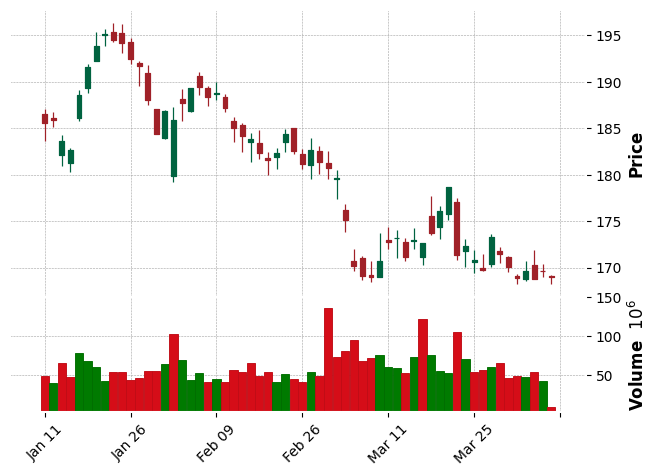

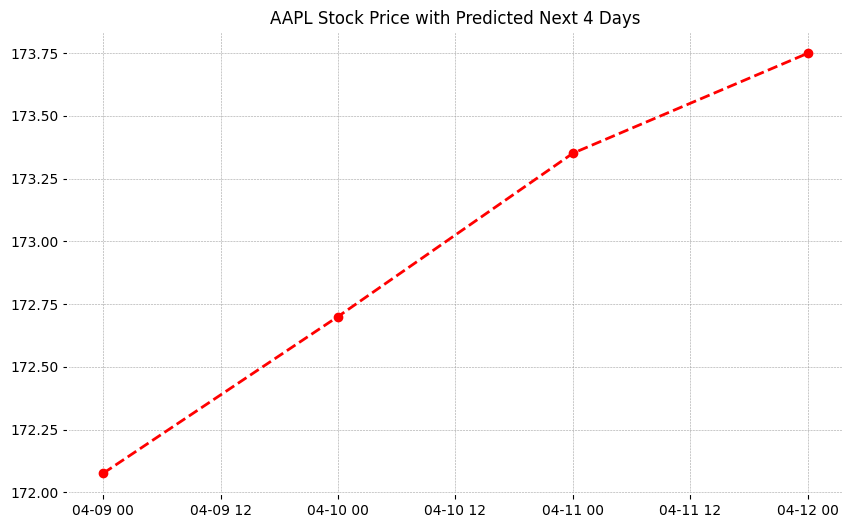

In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()



[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 63ms/step


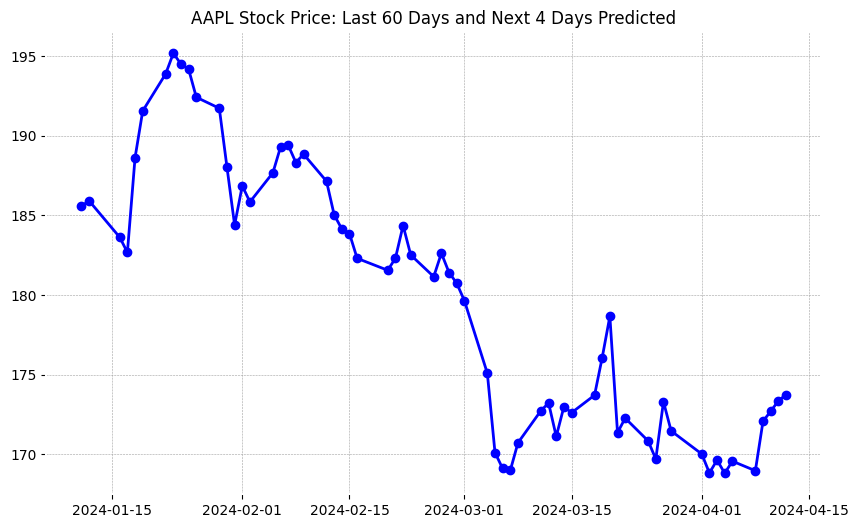

In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(combined_data, linestyle='-', marker='o', color='blue')
plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.show()


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 52ms/step


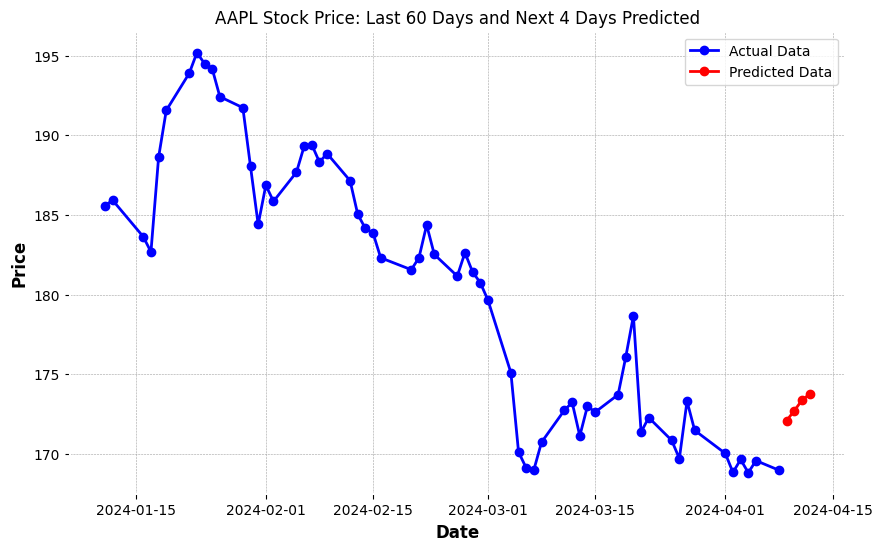

In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


def predict_stock_price(input_date):
    # Check if the input date is a valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Fetch data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
    data = yf.download('AAPL', start=start_date, end=end_date)

    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(4):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")

# Example use
user_input = input("Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: ")
predict_stock_price(user_input)


Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: 2024-04-06


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step
Day 1 prediction: 172.87551879882812
Day 2 prediction: 173.3972930908203
Day 3 prediction: 174.0642852783203
Day 4 prediction: 174.57908630371094


In [ ]:
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-18-24a063037cda> in <cell line: 16>()
     14 # Transpose the DataFrame to have states as rows and their respective rates as the columns
     15 unemp_data = unemp_data.T
---> 16 unemp_data.columns = ['UnemploymentRate']
     17
     18 # Convert the UnemploymentRate column to numeric

4 frames
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/base.py in _validate_set_axis(self, axis, new_labels)
     68
     69         elif new_len != old_len:
---> 70             raise ValueError(
     71                 f"Length mismatch: Expected axis has {old_len} elements, new "
     72                 f"values have {new_len} elements"

ValueError: Length mismatch: Expected axis has 416 elements, new values have 1 elements

In [2]:
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt: 

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qasimramzan","key":"2462182a50139c08cda011b917fe38b8"}'}

In [5]:
!pip install kaggle

In [6]:
!kaggle datasets download -d shaunthesheep/cats-vs-dogs

403 - Forbidden - Permission 'datasets.get' was denied


In [7]:
!unzip cats-vs-dogs.zip

unzip:  cannot find or open cats-vs-dogs.zip, cats-vs-dogs.zip.zip or cats-vs-dogs.zip.ZIP.


In [10]:
import os

# Import required libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import glob,os
import matplotlib.image as mpimg


In [11]:
new_path = "/kaggle/input/catsvsdogs/"

In [18]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/path_to_kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jojomoolayil/catsvsdogs -p /content/drive/MyDrive/catsvsdogs_dataset


cp: cannot stat '/content/drive/MyDrive/path_to_kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jojomoolayil/catsvsdogs
License(s): unknown
100% 545M/545M [00:29<00:00, 21.5MB/s]
100% 545M/545M [00:29<00:00, 19.5MB/s]


In [19]:
import pandas as pd

# Read a CSV file from the dataset
df = pd.read_csv('/content/drive/MyDrive/catsvsdogs_dataset/catsvsdogs.csv')

# Display the first few rows of the dataframe
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/catsvsdogs_dataset/catsvsdogs.csv'

In [22]:
!unzip /content/drive/MyDrive/catsvsdogs_dataset/catsvsdogs.zip -d /content/drive/MyDrive/catsvsdogs_dataset/
!ls /content/drive/MyDrive/catsvsdogs_dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4422.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4424.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4425.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4426.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4427.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4428.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4429.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.443.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4430.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4431.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4433.jpg  
  inflating: /content/drive/MyDrive/catsvsdogs_dataset/train/dog/dog.4

In [23]:
#df = pd.read_csv('/content/drive/MyDrive/catsvsdogs_dataset/catsvsdogs.csv')
#Compose sequence of transformations for image
transformations = transforms.Compose([
transforms.Resize(255),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
])
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder(os.path.join(new_path,"train")
, transform = transformations)
val_set = datasets.ImageFolder(os.path.join(new_path,"test")
, transform = transformations)
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set
, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32,
shuffle=True)
Note that train

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/catsvsdogs_dataset/catsvsdogs.csv'

In [13]:
#Collect Cat images
for img_path in glob.glob(os.path.join(new_path,"train","cat",
"*.jpg"))[:5]:
  images.append(mpimg.imread(img_path))
#Collect Dog images
for img_path in glob.glob(os.path.join(new_path,"train","dog",
"*.jpg"))[:5]:
  images.append(mpimg.imread(img_path))
#Plot a grid of cats and Dogs
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
  plt.subplot(len(images) / columns + 1, columns, i + 1)
  plt.imshow(image)

NameError: name 'images' is not defined

<Figure size 2000x1000 with 0 Axes>

In [14]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Initialize the images list
images = []

# Specify the path to the directory containing the images
#new_path = "path/to/your/dataset"  # Update this path

# Collect Cat images
for img_path in glob.glob(os.path.join(new_path, "train", "cat", "*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

# Collect Dog images
for img_path in glob.glob(os.path.join(new_path, "train", "dog", "*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

# Plot a grid of cats and dogs
plt.figure(figsize=(20, 10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

# Show the plot
plt.show()


<Figure size 2000x1000 with 0 Axes>

In [24]:
#Compose sequence of transformations for image
transformations = transforms.Compose([
  transforms.Resize(255),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225])
])
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder(os.path.join(new_path,"train")
, transform = transformations)
val_set = datasets.ImageFolder(os.path.join(new_path,"test")
, transform = transformations)
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set
, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32,
shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/catsvsdogs/train'

In [25]:
import os
import glob

# Path to the unzipped directory
data_dir = '/content/drive/MyDrive/catsvsdogs_dataset/'

# List all files and directories in the data directory
files_and_dirs = os.listdir(data_dir)
print("Files and Directories:")
print(files_and_dirs)

# Explore directory structure using os.walk
print("\nDirectory Structure:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for file in files:
        print('{}{}'.format(subindent, file))

# Count number of files and directories
num_files = len(glob.glob(data_dir + '/**/*', recursive=True))
num_dirs = len([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

print("\nNumber of Files:", num_files)
print("Number of Directories:", num_dirs)


Streaming output truncated to the last 5000 lines.
        dog.5037.jpg
        dog.10945.jpg
        dog.4454.jpg
        dog.1576.jpg
        dog.1600.jpg
        dog.5997.jpg
        dog.5127.jpg
        dog.2714.jpg
        dog.2602.jpg
        dog.5787.jpg
        dog.12388.jpg
        dog.2835.jpg
        dog.1122.jpg
        dog.11134.jpg
        dog.9792.jpg
        dog.3180.jpg
        dog.2129.jpg
        dog.1084.jpg
        dog.12168.jpg
        dog.3701.jpg
        dog.376.jpg
        dog.2101.jpg
        dog.7290.jpg
        dog.6983.jpg
        dog.7180.jpg
        dog.5867.jpg
        dog.10304.jpg
        dog.2438.jpg
        dog.8366.jpg
        dog.660.jpg
        dog.9255.jpg
        dog.8865.jpg
        dog.9308.jpg
        dog.4100.jpg
        dog.5202.jpg
        dog.5943.jpg
        dog.8898.jpg
        dog.8026.jpg
        dog.788.jpg
        dog.2733.jpg
        dog.1631.jpg
        dog.3254.jpg
        dog.7291.jpg
        dog.10404.jpg
        dog.1611.jpg
 

In [29]:
import torch
from torchvision import datasets, transforms

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/catsvsdogs_dataset/'

# Compose sequence of transformations for image
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load in each dataset and apply transformations using torchvision.datasets as datasets library
train_set = datasets.ImageFolder(os.path.join(dataset_path, "train"), transform=transformations)
val_set = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transformations)

# Put into a DataLoader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)


In [31]:
import torch
import torch.nn as nn

# Define Convolutional network
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        # First unit of convolution
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 112
        # Second unit of convolution
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 56
        # Third unit of convolution
        self.conv_unit_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 28
        # Fourth unit of convolution
        self.conv_unit_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 14
        # Fully connected layers
        self.fc1 = nn.Linear(14 * 14 * 128, 128)
        self.fc2 = nn.Linear(128, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = self.conv_unit_3(out)
        out = self.conv_unit_4(out)
        # Reshape the output
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.final(out)
        return out


In [32]:
def evaluate(model, data_loader):
    loss = []
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            model.eval()
            output = model(images)
            predicted = output > 0.5
            correct += (labels.reshape(-1, 1) == predicted.reshape(-1, 1)).float().sum()

            # Clear memory
            del images, labels
            if device == "cuda":
                torch.cuda.empty_cache()

        print('\nVal Accuracy: {}/{} ({:.3f}%)\n'.format(
            correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))


In [33]:
num_epochs = 10
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss
model = ConvNet()
model.cuda()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
total_step = len(train_loader)
print("Total Batches:", total_step)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs.float(), labels.float().view(-1, 1))

        # Backward and optimize
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()

        train_loss += loss.item() * labels.size(0)

    # Print epoch loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader.dataset)))

    # Evaluate model after each training epoch
    evaluate(model, val_loader)


Total Batches: 625
Epoch [1/10], Loss: 0.5660

Val Accuracy: 3705.0/5000 (74.100%)

Epoch [2/10], Loss: 0.4708

Val Accuracy: 3970.0/5000 (79.400%)

Epoch [3/10], Loss: 0.3973

Val Accuracy: 3996.0/5000 (79.920%)

Epoch [4/10], Loss: 0.3463

Val Accuracy: 4155.0/5000 (83.100%)

Epoch [5/10], Loss: 0.2974

Val Accuracy: 4211.0/5000 (84.220%)



KeyboardInterrupt: 

In [34]:
#Download the model (pretrained)
from torchvision import models
new_model = models.vgg16(pretrained=True)
# Freeze model weights
for param in new_model.parameters():
  param.requires_grad = False
print(new_model.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.6MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [35]:
#Define our custom model last layer
new_model.classifier[6] = nn.Sequential(
  nn.Linear(new_model.classifier[6].
  in_features, 256),
  nn.ReLU(),
  nn.Dropout(0.4),
  nn.Linear(256, 1),
  nn.Sigmoid())
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in new_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
  p.numel() for p in new_model.parameters()
  if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,633 total parameters.
1,049,089 training parameters.


In [36]:
# Define epochs, optimizer and loss function
num_epochs = 2
loss_function = nn.BCELoss()  # Binary Cross Entropy Loss
new_model.cuda()
adam_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)

# Train the model
total_step = len(train_loader)
print("Total Batches:", total_step)

for epoch in range(num_epochs):
    new_model.train()
    train_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = new_model(images)
        loss = loss_function(outputs.float(), labels.float().view(-1, 1))

        # Backward and optimize
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()

        train_loss += loss.item() * labels.size(0)

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')

    # Evaluate the model after each epoch
    evaluate(new_model, val_loader)


Total Batches: 625
Epoch [1/2], Average Train Loss: 0.0553

Val Accuracy: 4930.0/5000 (98.600%)

Epoch [2/2], Average Train Loss: 0.0390

Val Accuracy: 4917.0/5000 (98.340%)



In [38]:
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format
License(s): world-bank
100% 25.7M/25.7M [00:02<00:00, 17.7MB/s]
100% 25.7M/25.7M [00:02<00:00, 10.8MB/s]


In [42]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn, optim
import torchtext
from torchtext import data

# Check if we have GPU enabled
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Device =", device)

input_data_path = "/kaggle/input/imdb-dataset-sentimentanalysis-in-csv-format/"


Device = cuda


In [41]:
#Read the csv dataset using pandas
df = pd.read_csv("/input/imdb-dataset-sentiment-analysis-incsv-format/Train.csv")
print("DF.shape :\n",df.shape)
print("df.label = ",df.label.value_counts())
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/input/imdb-dataset-sentiment-analysis-incsv-format/Train.csv'

In [43]:
# Read the csv dataset using pandas
df = pd.read_csv("/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv")
print("DF.shape :\n",df.shape)
print("df.label = ",df.label.value_counts())
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv'